In [160]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from tqdm import tqdm, trange
from IPython.display import clear_output

# Image Panorama Stitching

In [49]:
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

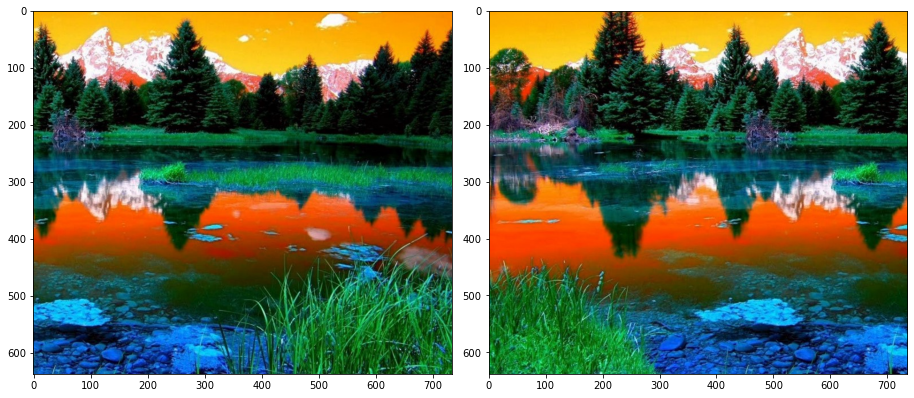

In [50]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.subplot(121)
plt.imshow(img1,)

plt.subplot(122)
plt.imshow(img2,)

fig.tight_layout()
plt.show()

In [51]:
descriptor = cv2.SIFT_create()

In [52]:
kp1, desc1 = descriptor.detectAndCompute(img1, None)
kp2, desc2 = descriptor.detectAndCompute(img2, None)

kNN mathcer

![alt text](knn_example.png "Title")

In [53]:
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params, search_params)
flann = cv2.BFMatcher()

In [54]:
matches = flann.match(desc2, desc1)
print(matches[0].distance)

matches = flann.knnMatch(desc2, desc1, k=2)
print([m.distance for m in matches[0]])

319.2679138183594
[319.2679138183594, 332.792724609375]


In [55]:
if (desc1 is not None and desc2 is not None and len(desc1) >=2 and len(desc2) >= 2):
    rawMatch = flann.knnMatch(desc2, desc1, k=2)
    matches = []
    # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    ratio = 0.75
    for m in rawMatch:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append(m[0])

In [56]:
list_kp1 = np.array([kp1[mat.trainIdx].pt for mat in matches])
list_kp2 = np.array([kp2[mat.queryIdx].pt for mat in matches])

In [57]:
if len(matches) > 4:
    (H, status) = cv2.findHomography(list_kp1, list_kp2, cv2.RANSAC)

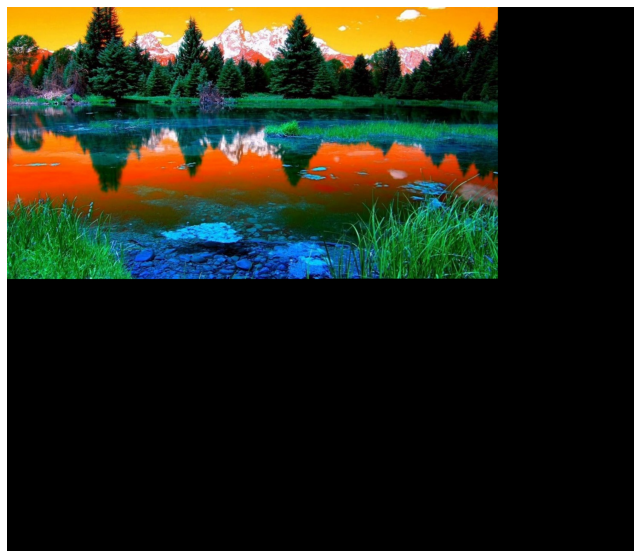

In [58]:
# Apply panorama correction
width = img1.shape[1] + img2.shape[1]
height = img2.shape[0] + img2.shape[0]

result = cv2.warpPerspective(img1, H, (width, height))

result[0:img2.shape[0], 0:img2.shape[1]] = img2
idx_w = np.argwhere(result[0, :] == 0)
idx_h = np.argwhere(result[:, 0] == 0)

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

# Pazzle

## Step by step 

In [25]:
def crop(image):
    # left crop
    while not image[0].any():
        image = image[1:]
    # right crop
    while not image[-1].any():
        image = image[:-1]
    # top crop
    while not image[:, 0].any():
        image = image[:, 1:]
    # bottom crop
    while not image[:, -1].any():
        image = image[:, :-1]
    return image

def crops(images):
    for image in images:
        image = crop(image)

In [235]:
def get_images(path="puzzle/china_shuffle"):
    images_path = os.listdir(path)
    images = []
    for im in images_path:
        img = cv2.imread(os.path.join(path, im))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        images.append(img)

    return np.array(images)

In [63]:
path = 'puzzle/home_shuffle'
images = get_images(path)[3:5]

In [64]:
img1, img2 = images[0], images[1]

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1[:, :, 0], None)
kp2, des2 = sift.detectAndCompute(img2[:, :, 0], None)
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

print(des1.shape, des2.shape)

(191, 128) (14, 128)


In [65]:
matches = bf.match(des1, des2)

for i in range(3):
    m = matches[i]
    line = 'match info: \n1) distance: {}\n2) imgIdx: {}\n3) queryIdx: {}\n4) trainIdx: {}'.format(m.distance, m.imgIdx, m.queryIdx, m.trainIdx)
    print(line)

match info: 
1) distance: 3280.0
2) imgIdx: 0
3) queryIdx: 0
4) trainIdx: 8
match info: 
1) distance: 2106.0
2) imgIdx: 0
3) queryIdx: 1
4) trainIdx: 13
match info: 
1) distance: 2021.0
2) imgIdx: 0
3) queryIdx: 2
4) trainIdx: 13


In [66]:
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:10]

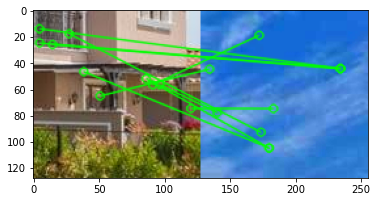

In [67]:
#-- Draw matches
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                  )

cv2.drawMatches(img1, kp1, img2, kp2, good_matches, img_matches, **draw_params)

#-- Show detected matches
plt.imshow(img_matches)

In [68]:
list_kp1 = np.array([kp1[mat.queryIdx].pt for mat in good_matches])
list_kp2 = np.array([kp2[mat.trainIdx].pt for mat in good_matches])

print(list_kp1)

[[ 86.06786346  51.88145065]
 [ 38.37688065  46.47964859]
 [ 96.41956329  56.37277603]
 [ 91.08079529  56.49084854]
 [120.17428589  74.52334595]
 [  4.63312054  24.53796577]
 [ 14.50330639  25.84669304]
 [ 27.14614296  17.54631424]
 [ 50.85381317  65.00162506]
 [  4.45954514  13.78806877]]


In [69]:
x, y = list_kp1[:, 0] - list_kp2[:, 0], list_kp1[:, 1] - list_kp2[:, 1]
angles = [math.degrees(math.atan2(y[elem], x[elem])) for elem in range(len(x))]

np.std(angles)

77.15968943910781

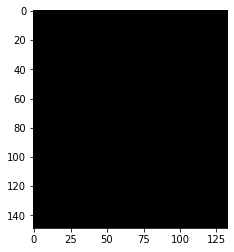

In [70]:
diff_x, diff_y = int(np.mean(x)), int(np.mean(y))

img3 = np.zeros((max(img1.shape[0], abs(diff_y) + img2.shape[0], img1.shape[0] - diff_y),
                 max(img1.shape[1], abs(diff_x) + img2.shape[1], img1.shape[1] - diff_x), 3))

plt.imshow(img3)

In [71]:
diff_x1, diff_y1 = max(0, -diff_x), max(0, -diff_y)
diff_x2, diff_y2 = max(0, diff_x), max(0, diff_y)

print(diff_x1, diff_y1)
print(diff_x2, diff_y2)

img3[diff_y1:diff_y1 + img1.shape[0], diff_x1:diff_x1 + img1.shape[1]] = img1
img3[diff_y2:diff_y2 + img2.shape[0], diff_x2:diff_x2 + img2.shape[1]] = img2

5 21
0 0


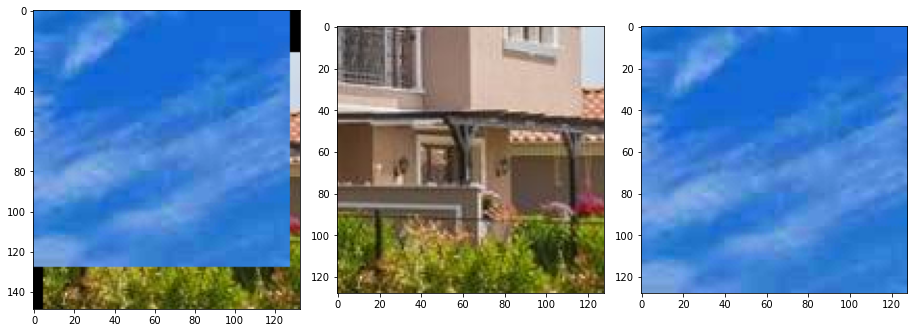

In [72]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.subplot(131)
plt.imshow(img3.astype(np.uint8))

plt.subplot(132)
plt.imshow(img1)

plt.subplot(133)
plt.imshow(img2)

fig.tight_layout()
plt.show()

## All solution

In [79]:
def stitcher(img1, img2, match_number=20, best_match_number=5, angle_eps=2):
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

    if des2 is not None and des1 is not None:
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        if len(matches) > match_number:
            matches = matches[:best_match_number]
            list_kp1 = np.array([kp1[mat.queryIdx].pt for mat in matches])
            list_kp2 = np.array([kp2[mat.trainIdx].pt for mat in matches])
            x, y = list_kp1[:, 0] - list_kp2[:, 0], list_kp1[:, 1] - list_kp2[:, 1]
            angles = [math.degrees(math.atan2(y[elem], x[elem])) for elem in range(len(x))]

            if np.std(angles) < angle_eps:
                diff_x, diff_y = int(np.mean(x)), int(np.mean(y))
                img3 = np.zeros((max(img1.shape[0], abs(diff_y) + img2.shape[0], img1.shape[0] - diff_y),
                                 max((img1.shape[1], abs(diff_x) + img2.shape[1], img1.shape[1] - diff_x)), 3))
                diff_x1, diff_y1 = max(0, -diff_x), max(0, -diff_y)
                diff_x2, diff_y2 = max(0, diff_x), max(0, diff_y)

                img3[diff_y1:diff_y1 + img1.shape[0], diff_x1:diff_x1 + img1.shape[1]] = img1
                img3[diff_y2:diff_y2 + img2.shape[0], diff_x2:diff_x2 + img2.shape[1]] = img2
                return img3

In [141]:
path = 'puzzle/china_shuffle'
images = get_images(path)
random_idxs = np.arange(0, len(images))
np.random.shuffle(random_idxs)
# images = images[random_idxs]

In [142]:
# sift = cv2.SIFT_create()


In [231]:
def get_possible_stitched(images, iterations = 10):
    res = np.zeros_like(images[0])
    for i in trange(iterations):
        cimages = images.copy()
        idx = np.random.randint(0, len(cimages))
        cur_res = images[idx]
        cimages = np.delete(cimages, idx, 0)
        count = 0

        for count in range(150):
            if len(cimages) < 1:
                break
            idx = np.random.randint(0, len(cimages))
            cur = stitcher(cur_res, cimages[idx])  # match_number=20 // (k + 1), best_match_number=5 + 3 * k, angle_eps=2 + 5 * k)
            if cur is not None:
                cur_res = cur
                cimages = np.delete(cimages, idx, 0)
        if np.count_nonzero(res) <= np.count_nonzero(res) and cv2.mean(res) <= cv2.mean(cur_res):
            res = cur_res
    return res

In [194]:
res = get_possible_stitched(images)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:40<00:00, 46.10s/it]


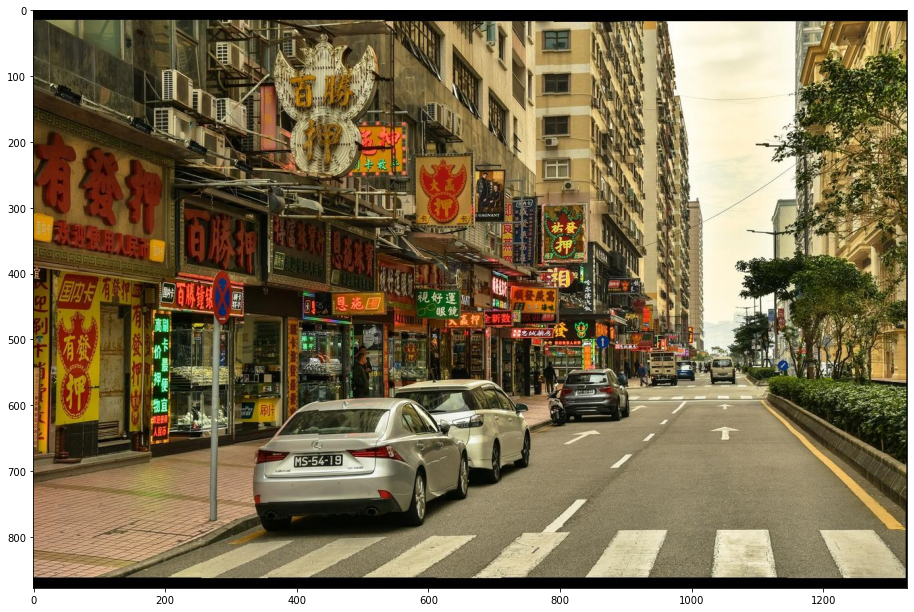

In [195]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.imshow(crop(res.astype(np.uint8)))

fig.tight_layout()
plt.show()

In [236]:
path = 'puzzle/su_fighter_shuffle'
images = get_images(path)

In [237]:
res = get_possible_stitched(images)





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.63it/s]



 20%|████████████████▌                                                                  | 2/10 [00:03<00:09,  1.21s/it]



 30%|████████████████████████▉                                                          | 3/10 [00:04<00:07,  1.10s/it]



 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:05,  1.02it/s]



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.49s/it]



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:20<00:19,  4.83s/it]



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:21<00:11,  3.87s/it]



 80%|███████

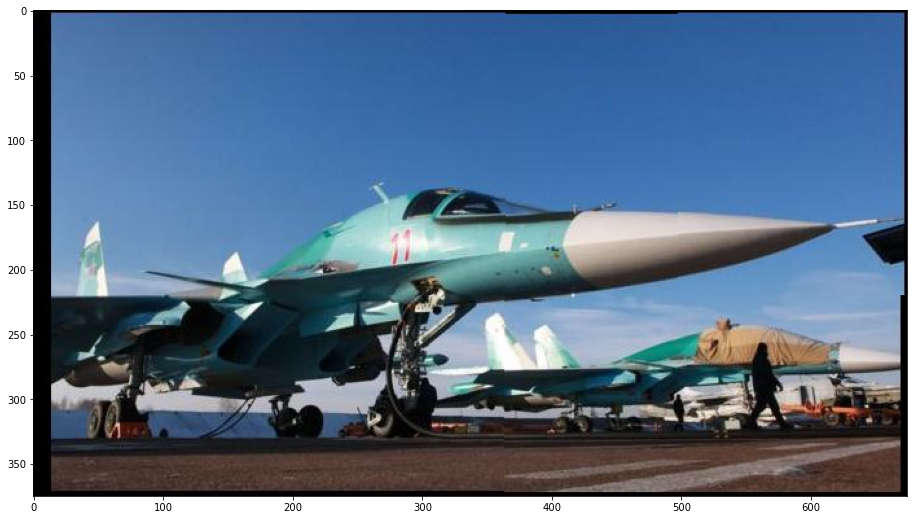

In [238]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.imshow(crop(res.astype(np.uint8)))

fig.tight_layout()
plt.show()

In [226]:
path = 'puzzle/home_shuffle'
images = get_images(path)

In [229]:
res = get_possible_stitched(images, iterations = 50)





  0%|                                                                                           | 0/50 [00:00<?, ?it/s]



  2%|█▋                                                                                 | 1/50 [00:01<01:20,  1.65s/it]



  4%|███▎                                                                               | 2/50 [00:03<01:26,  1.80s/it]



  6%|████▉                                                                              | 3/50 [00:05<01:17,  1.65s/it]



  8%|██████▋                                                                            | 4/50 [00:06<01:07,  1.46s/it]



 10%|████████▎                                                                          | 5/50 [00:07<01:07,  1.51s/it]



 12%|█████████▉                                                                         | 6/50 [00:10<01:17,  1.76s/it]



 14%|███████████▌                                                                       | 7/50 [00:15<02:07,  2.98s/it]



 16%|███████

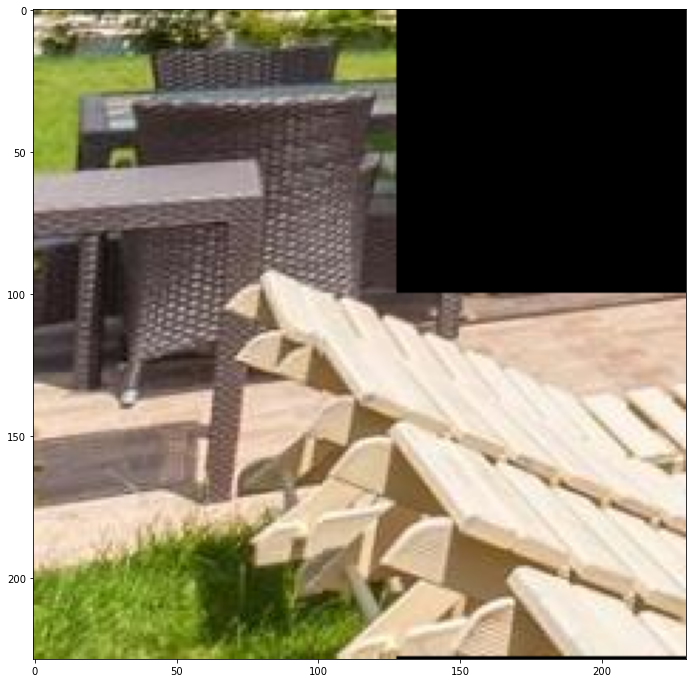

In [230]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.imshow(crop(res.astype(np.uint8)))

fig.tight_layout()
plt.show()

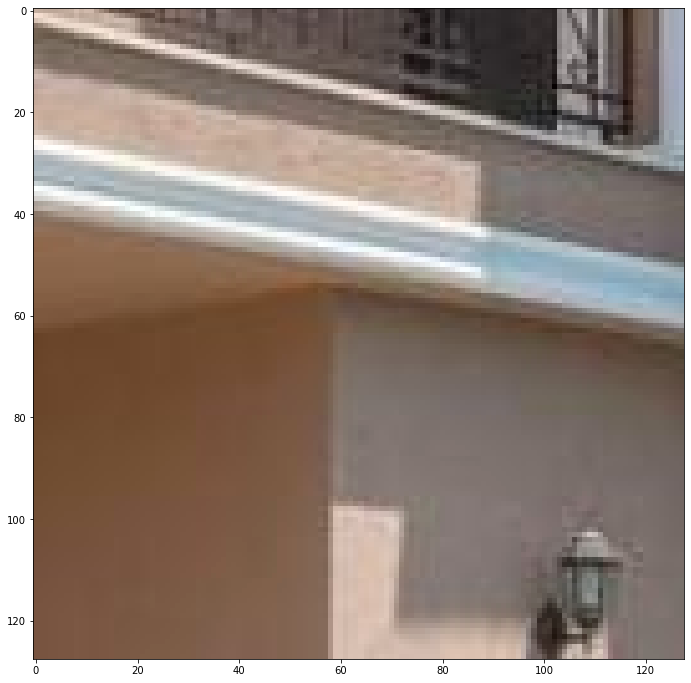

In [188]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.imshow(res.astype(np.uint8))

fig.tight_layout()
plt.show()

In [218]:
stitcher = cv2.Stitcher_create()


In [233]:
result, img = stitcher.stitch(images)

In [235]:
res = get_possible_stitched(images)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

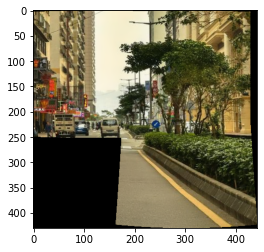

In [236]:
plt.imshow(img.astype(np.uint8))

In [13]:
path = 'puzzle/home_shuffle'
images = get_images(path)
random_idxs = np.arange(0, len(images))
np.random.shuffle(random_idxs)
images = images[random_idxs]

NameError: name 'crop' is not defined

In [ ]:
result, img = stitcher.stitch(images)
plt.imshow(img)